In [1]:
#import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math

In [2]:
#Data sequencing function 
def univariate_single_step(sequence, window_size):
    x, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

# Training Function
def training(num_epochs, train_iter, test_iter, optimiser, loss_fn, model):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for t in range(num_epochs):
        # Initialise hidden state
        #     Don't do this if you want your LSTM to be stateful
        #     model.hidden = model.init_hidden()
        running_loss_train = 0
        running_loss_valid = 0
        for _, (train_X, train_Y) in enumerate(train_iter):
            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to perform MSE
            y_train_pred = torch.reshape(y_train_pred, (train_Y.shape[0], train_Y.shape[1]))

            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimiser.step()

            running_loss_train += loss_train.item()

        epoch_loss_train = running_loss_train / len(train_X)
        train_loss[t] = epoch_loss_train

        with torch.no_grad():
            for _, (test_X, test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                # Reshape to perform MSE
                y_test_pred = torch.reshape(y_test_pred, (test_Y.shape[0], test_Y.shape[1]))
                loss_test = loss_fn(y_test_pred, test_Y)
                running_loss_valid += loss_test.item()

        epoch_loss_test = running_loss_valid / len(test_X)

        val_loss[t] = epoch_loss_test

    return train_loss, val_loss

In [3]:
split_ratio = 0.70
num_epochs = 60
window_size = 3
batch_size = 1
learning_rate=0.01
#seed
torch.manual_seed(123)

In [4]:
#Synthetic Data
univariate_series = np.array([x for x in range(0, 400, 10)])
print(univariate_series.shape)
univariate_series

(40,)


array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390])

In [5]:
split_data = round(len(univariate_series)*split_ratio)
split_data

28

In [6]:
#split data by indexing 
train_data = univariate_series[:split_data]
test_data = univariate_series[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(28,)
test_data_shape
(12,)


In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

test_data_normalized = scaler.fit_transform(test_data.reshape(-1, 1))

In [8]:
trainX ,trainY =  univariate_single_step(train_data_normalized,window_size)
testX , testY = univariate_single_step(test_data_normalized,window_size)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(25, 3, 1) trainY shape:(25, 1)

testX shape:(9, 3, 1) testY shape:(9, 1)


In [9]:
#transfrom to Pytorch tensor
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:torch.Size([25, 3, 1]) trainY shape:torch.Size([25, 1])

testX shape:torch.Size([9, 3, 1]) testY shape:torch.Size([9, 1])


In [10]:
# Data Transpose
trainX = torch.transpose(trainX, 1, 2)
testX = torch.transpose(testX, 1, 2)

In [11]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset,batch_size=1,shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset,batch_size=1,shuffle=False)

## CNN-LSTM Configuration 

In [12]:
class CNN(nn.Module):
    def __init__(self,n_timeseries,n_out_dim):
        super(CNN, self).__init__()
        self.n_timeseries = n_timeseries
        self.n_out_dim = n_out_dim
        self.conv1 = nn.Conv1d(in_channels = n_timeseries,out_channels=10, kernel_size=2)
        self.poo1 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(10, 20)
        self.fc2 = nn.Linear(20, n_out_dim)

    def forward(self, x):
        x = self.poo1(F.relu(self.conv1(x)))
        x = x.view(-1, 10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class Combine(nn.Module):
    def __init__(self,n_timeseries,n_output,hidden_size=64):
        super(Combine, self).__init__()
        self.n_timeseries = n_timeseries
        self.n_output = n_output
        self.hidden_size = hidden_size
        self.num_layers = 1

        self.cnn = CNN(n_timeseries,n_output)

        self.lstm = nn.LSTM(
            input_size= n_timeseries,
            hidden_size= hidden_size,
            num_layers=1,
            batch_first=True)
        self.linear = nn.Linear(hidden_size,n_output)

    def forward(self, x):
        c_out = self.cnn(x)

        # Reshape the c_out to fit in LSTM
        c_out = torch.reshape(c_out,(c_out.shape[0],c_out.shape[1],1))

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out, (hn, cn) = self.lstm(c_out, (h0.detach(), c0.detach()))
        r_out2 = self.linear(out[:, -1, :])

        return r_out2

In [13]:
model = Combine(n_timeseries=trainX.shape[1],n_output=1)
print(model.eval())

#loss function
loss_fn = torch.nn.MSELoss()

#optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)



Combine(
  (cnn): CNN(
    (conv1): Conv1d(1, 10, kernel_size=(2,), stride=(1,))
    (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=10, out_features=20, bias=True)
    (fc2): Linear(in_features=20, out_features=1, bias=True)
  )
  (lstm): LSTM(1, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [14]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(weights_init)

Combine(
  (cnn): CNN(
    (conv1): Conv1d(1, 10, kernel_size=(2,), stride=(1,))
    (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=10, out_features=20, bias=True)
    (fc2): Linear(in_features=20, out_features=1, bias=True)
  )
  (lstm): LSTM(1, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [15]:
train_loss, val_loss = training(num_epochs, train_iter, test_iter, optimiser, loss_fn, model)

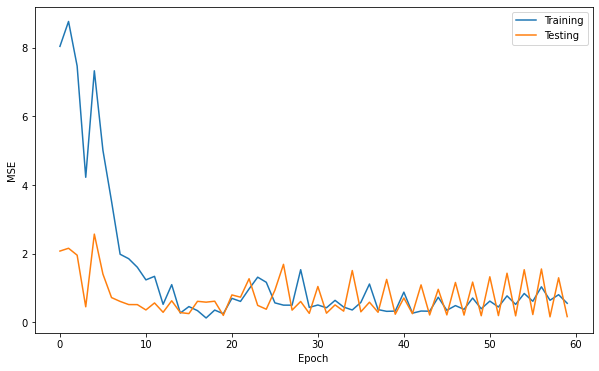

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [17]:
# make predictions
with torch.no_grad():
    y_train_prediction = model(trainX)
    y_test_prediction = model(testX)

In [18]:
# Reshape to original data
y_train_prediction = torch.reshape(y_train_prediction, (y_train_prediction.shape[0], y_train_prediction.shape[1]))
trainY = torch.reshape(trainY, (trainY.shape[0], trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction, (y_test_prediction.shape[0], y_test_prediction.shape[1]))
testY = torch.reshape(testY, (testY.shape[0], testY.shape[1]))

In [19]:
# Invert predictions
y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(trainY.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(testY.detach().numpy())

In [20]:
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")

[310.]		[314.1309]
[320.]		[317.25177]
[330.]		[324.51364]
[340.]		[337.4923]
[350.]		[345.7808]
[360.]		[352.28738]
[370.]		[359.23114]
[380.]		[368.7375]
[390.]		[379.1978]


In [21]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 9.04 RMSE
Test Score: 7.44 RMSE


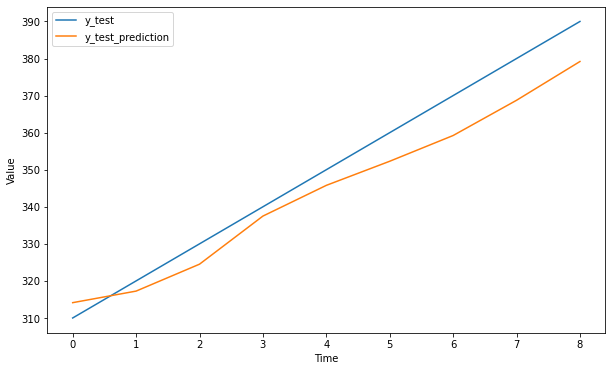

In [22]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label="y_test")
plt.plot(y_test_prediction, label="y_test_prediction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

## Exercise for Univariate (Solution)
Use CNN to predict the sales of shampoo \
Data Sources : https://www.kaggle.com/djokester/sales-of-shampoo-over-a-three-year-period

In [56]:
#Hyperparameter
num_epochs_shampoo = 180
split_ratio = 0.70
batch_size_shampoo = 1
window_size_shampoo = 3
learning_rate_shampoo = 0.1
#Hidden Layer for LSTM
hidden_dim = 32

#seed
torch.manual_seed(123)

In [26]:
shampoo = pd.read_csv('C:/Users/boonkai.yeoh/Desktop/shampoo-sales.csv')
# shampoo = pd.read_csv('../datasets/others/shampoo-sales.csv')
shampoo_ts =shampoo['sales']
shampoo_ts.head()

0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
Name: sales, dtype: float64

In [27]:
split_data = round(len(shampoo_ts)*split_ratio)
split_data

25

In [28]:
train_data_shampoo = shampoo_ts[:split_data]
test_data_shampoo = shampoo_ts[split_data:]
train_time = shampoo_ts.index[:split_data]
test_time = shampoo_ts.index[split_data:]
print("train_data_shampoo_shape")
print(train_data_shampoo.shape)
print("test_data_shampoo_shape")
print(test_data_shampoo.shape)

train_data_shampoo_shape
(25,)
test_data_shampoo_shape
(11,)


In [29]:
#Data Normalization

#Reshape before normalize
train_data_shampoo = train_data_shampoo.values.reshape(-1, 1)
test_data_shampoo = test_data_shampoo.values.reshape((-1, 1))

#Build Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized_shampoo = scaler.fit_transform(train_data_shampoo)

test_data_normalized_shampoo = scaler.fit_transform(test_data_shampoo)
train_data_normalized_shampoo[1:6]

array([[-0.82401588],
       [-0.57790275],
       [-1.        ],
       [-0.59642739],
       [-0.67449553]])

In [30]:
#Data Sequencing 
trainX_shampoo ,trainY_shampoo =  univariate_single_step(train_data_normalized_shampoo,window_size_shampoo)
testX_shampoo , testY_shampoo = univariate_single_step(test_data_normalized_shampoo,window_size_shampoo)
print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testX shape:{testY_shampoo.shape}")

trainX shape:(22, 3, 1) trainY shape:(22, 1)

testX shape:(8, 3, 1) testX shape:(8, 1)


In [31]:
#Transfrom numpy to Pytorch tensor
# make training and test sets in torch
trainX_shampoo = torch.from_numpy(trainX_shampoo).type(torch.Tensor)
trainY_shampoo = torch.from_numpy(trainY_shampoo).type(torch.Tensor)
testX_shampoo = torch.from_numpy(testX_shampoo).type(torch.Tensor)
testY_shampoo = torch.from_numpy(testY_shampoo).type(torch.Tensor)
print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testX shape:{testY_shampoo.shape}")

trainX shape:torch.Size([22, 3, 1]) trainY shape:torch.Size([22, 1])

testX shape:torch.Size([8, 3, 1]) testX shape:torch.Size([8, 1])


In [40]:
# Data Transpose
trainX_shampoo = torch.transpose(trainX_shampoo, 1, 2)
testX_shampoo  = torch.transpose(testX_shampoo,1, 2)

In [41]:
# Create Iterator
train_dataset_shampoo = TensorDataset(trainX_shampoo, trainY_shampoo)
train_iter_shampoo = DataLoader(train_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)

test_dataset_shampoo = TensorDataset(testX_shampoo, testY_shampoo)
test_iter_shampoo = DataLoader(test_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)

In [57]:
model_shampoo  = Combine(n_timeseries=trainX_shampoo.shape[1],n_output=1)
print(model_shampoo.eval())

#loss function
loss_fn_shampoo = torch.nn.MSELoss()

#optimiser
optimiser_shampoo = torch.optim.SGD(model_shampoo.parameters(), lr=learning_rate_shampoo)

Combine(
  (cnn): CNN(
    (conv1): Conv1d(1, 10, kernel_size=(2,), stride=(1,))
    (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=10, out_features=20, bias=True)
    (fc2): Linear(in_features=20, out_features=1, bias=True)
  )
  (lstm): LSTM(1, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [58]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model_shampoo.apply(weights_init)

Combine(
  (cnn): CNN(
    (conv1): Conv1d(1, 10, kernel_size=(2,), stride=(1,))
    (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=10, out_features=20, bias=True)
    (fc2): Linear(in_features=20, out_features=1, bias=True)
  )
  (lstm): LSTM(1, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [59]:

train_loss_shampoo,val_loss_shampoo = training(num_epochs_shampoo,train_iter_shampoo,test_iter_shampoo,optimiser_shampoo,loss_fn_shampoo,model_shampoo)

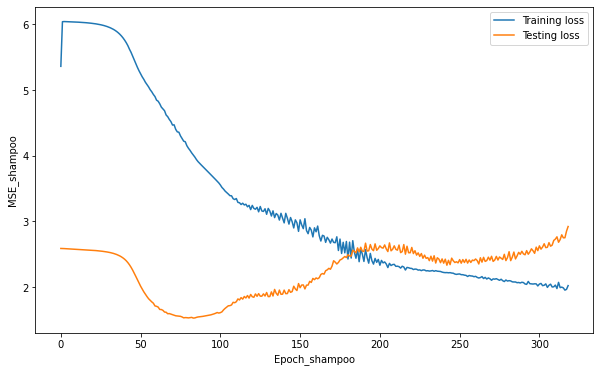

In [45]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_shampoo, label="Training loss")
plt.plot(val_loss_shampoo, label="Testing loss")
plt.xlabel("Epoch_shampoo")
plt.ylabel("MSE_shampoo")
plt.legend()
plt.show()

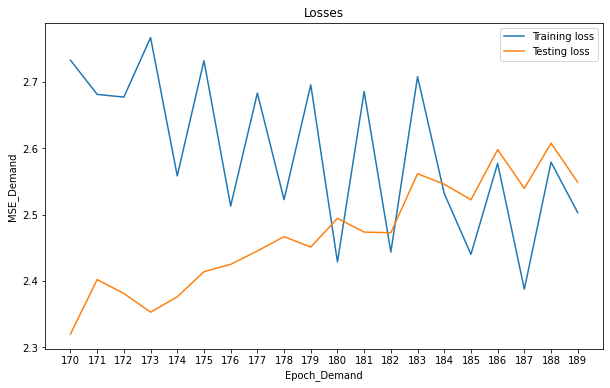

In [55]:
# Zoom in by fill in start_epoch and end_epoch
start_epoch = 170
end_epoch = 190
plt.figure(figsize=(10,6))
plt.plot(train_loss_shampoo[start_epoch:end_epoch], label="Training loss")
plt.plot(val_loss_shampoo[start_epoch:end_epoch], label="Testing loss")
plt.title("Losses")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
position=range(end_epoch-start_epoch)
labels=range(start_epoch,end_epoch)
plt.xticks(position, labels)
plt.legend()
plt.show()

In [60]:
#Make predictions
y_train_prediction_shampoo= model_shampoo(trainX_shampoo)
y_test_prediction_shampoo= model_shampoo(testX_shampoo)

#Reshape to original data
y_train_prediction_shampoo = torch.reshape(y_train_prediction_shampoo,(y_train_prediction_shampoo.shape[0],y_train_prediction_shampoo.shape[1]))
trainY_shampoo = torch.reshape(trainY_shampoo,(trainY_shampoo.shape[0],trainY_shampoo.shape[1]))
y_test_prediction_shampoo = torch.reshape(y_test_prediction_shampoo,(y_test_prediction_shampoo.shape[0],y_test_prediction_shampoo.shape[1]))
testY_shampoo = torch.reshape(testY_shampoo,(testY_shampoo.shape[0],testY_shampoo.shape[1]))

In [61]:
#Invert predictions
y_train_pred_shampoo = scaler.inverse_transform(y_train_prediction_shampoo.detach().numpy())
y_train_shampoo = scaler.inverse_transform(trainY_shampoo.detach().numpy())
y_test_pred_shampoo = scaler.inverse_transform(y_test_prediction_shampoo.detach().numpy())
y_test_shampoo = scaler.inverse_transform(testY_shampoo.detach().numpy())

In [62]:
print("y-test\t\ty-predict")
for i in range(len(y_test_shampoo)):
    print(f"{y_test_shampoo[i]}\t\t{y_test_pred_shampoo[i]}")

y-test		y-predict
[401.30002]		[447.54437]
[437.4]		[466.39102]
[575.5]		[471.12848]
[407.60004]		[380.98822]
[682.]		[539.69006]
[475.3]		[466.1985]
[581.3]		[558.8116]
[646.9]		[597.27747]


In [63]:
#calculate root mean squared error
trainScore_shampoo = math.sqrt(mean_squared_error(y_train_shampoo[:,0], y_train_pred_shampoo[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_shampoo))
testScore_shampoo = math.sqrt(mean_squared_error(y_test_shampoo[:,0], y_test_pred_shampoo[:,0]))
print('Test Score: %.2f RMSE' % (testScore_shampoo))

Train Score: 66.59 RMSE
Test Score: 68.81 RMSE


In [64]:
# Adjust to make the sequence data plot on original test data 
a=range(split_data+window_size_shampoo,split_data+len(y_test_shampoo)+window_size_shampoo)

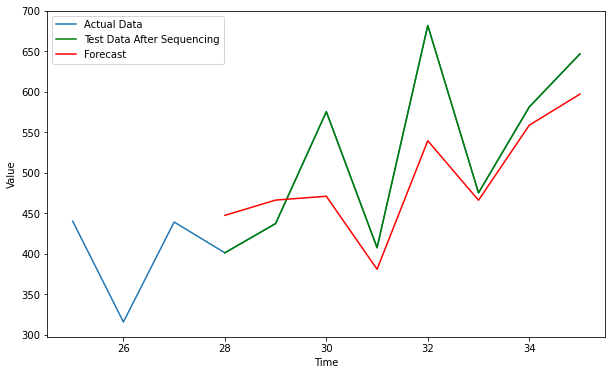

In [65]:

plt.figure(figsize=(10,6))
plt.plot(test_time,test_data_shampoo, label = 'Actual Data')
plt.plot(a,y_test_shampoo, color="green",label = 'Test Data After Sequencing')
plt.plot(a,y_test_pred_shampoo,color="red", label = 'Forecast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

## Reference
1. Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee
2. https://www.kaggle.com/hanjoonchoe/cnn-time-series-forecasting-with-pytorch